# 0. Install Dependencies

In [ ]:
!pip install tensorflow==2.3.1 gym keras-rl2 gym[atari,accept-rom-license]
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

# 1. Test Random Environment with OpenAI Gym

In [1]:
import gym 
import random

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar


# Unpack The ROM

* The next cell will display an inline dialog Box<br>
* Insert "A" in the cell field and hit Enter 

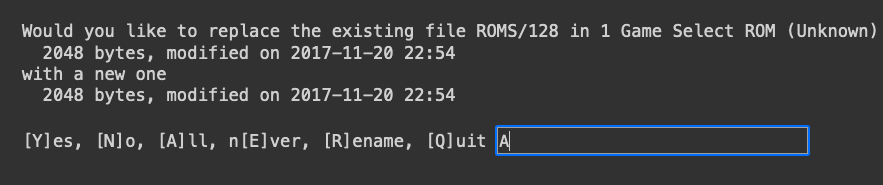

In [ ]:
!unrar x Roms.rar

In [ ]:
!python -m atari_py.import_roms "/content/HC ROMS/BY ALPHABET/S-Z"

In [8]:
env = gym.make('SpaceInvaders-v0')
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [ ]:
env.unwrapped.get_action_meanings()

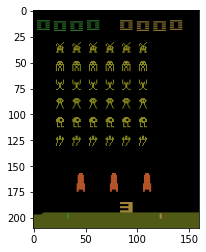

In [10]:
from pyvirtualdisplay import Display
Display().start()


from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
img = plt.imshow(env.render('rgb_array')) # only call this once

In [5]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        img.set_data(env.render('rgb_array'))
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:115.0
Episode:2 Score:105.0
Episode:3 Score:5.0
Episode:4 Score:55.0
Episode:5 Score:120.0


# 2. Create a Deep Learning Model with Keras

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

In [7]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [13]:
# CAUTION
# run this to solve "ValueError: Tensor must be from the same graph as Tensor" tha will occur on cell 24
# and rebuild the model (run all subsequent cells)
del model

In [14]:
model = build_model(height, width, channels, actions)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 67584)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               34603520  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 6)                

# 3. Build Agent with Keras-RL

In [16]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [17]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [18]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-4))

In [ ]:
dqn.fit(env, nb_steps=1000, visualize=False, verbose=2)

In [ ]:
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


In [20]:
scores = dqn.test(env, nb_episodes=30, visualize=True)
print(np.mean(scores.history['episode_reward']))

Testing for 3 episodes ...
Episode 1: reward: 40.000, steps: 674
Episode 2: reward: 40.000, steps: 677
Episode 3: reward: 35.000, steps: 677
38.333333333333336


# 4. Reloading Agent from Memory

In [21]:
dqn.save_weights('SavedWeights/10k-Fast/dqn_weights.h5f')

In [22]:
del model, dqn

In [ ]:
dqn.load_weights('SavedWeights/1m/dqn_weights.h5f')